<a href="https://colab.research.google.com/github/AmauryFaure/project_article_1/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet Article 1 :


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing pandas and numpy
import pandas as pd
import numpy as np

In [ ]:
#Check python version
!python --version

Python 3.6.9


In [ ]:
#List all packages.
pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
appdirs                       1.4.4          
argon2-cffi                   20.1.0         
asgiref                       3.3.1          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.3.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.9.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.3.

## Creating the training Dataset :

In [ ]:
#Get tweets
df_to_moderate=pd.read_csv("/content/drive/MyDrive/article_1_data/selected_tweets.csv")
#Drop unused data
df_to_moderate=df_to_moderate.drop(["Id","source","Looked up word"],axis=1)
#Change column name
df_to_moderate["content"]=df_to_moderate["tweet (without @)"]
df_to_moderate=df_to_moderate.drop(["tweet (without @)"], axis=1)
#Drop empty lines
df_to_moderate=df_to_moderate.dropna()

In [ ]:
#Get regular data
df_article1_messages=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuNormal")
#Drop unused data
df_article1_messages=df_article1_messages.drop(["_id","sender","recipients.0","threadId","timestamp","EchantillonNormal"], axis=1)
#Assign label
df_article1_messages["Harmful"]=0

In [ ]:
#Create training dataset. Balanced 50% for each class !
df_to_moderate=pd.concat([df_article1_messages[:200],df_to_moderate],ignore_index=True)

## Creating the test Dataset

Problem : we do not have a balanced Dataset of real examples from article 1 for which we know the real distribution.

What will we done instead :

- Test on the dataset of MLMA tweets. 
- See % that come back on Article 1 dataset. 

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/article_1_data/fr_dataset_test.csv")
#Dropping Unused columns
test=test.drop(test.columns[[7,8,9]],axis=1)
test=test.drop(columns=["HITId","directness","annotator_sentiment","target","group"])
#Changing sentiment to 0 (for normal) and 1 (for else) 
test["sentiment"]=[0 if test["sentiment"][x]=="normal" else 1 for x in range(test.shape[0])]

## Implementing BoW and TF-IDF

In [ ]:
#Creating arrays for test_values and labels
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])
# Same but for training
train_values=np.array(df_to_moderate["content"])
#Extra step to Making sure everything is on a string format (some numbers might not be)
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [ ]:

from joblib import dump, load

#Import SGDClassifier (allows to implement logistic regression)
from sklearn.linear_model import SGDClassifier
#Import matplotlib for plots
%matplotlib inline
import matplotlib.pyplot as plt
#Import some metrics
from sklearn.metrics import precision_recall_curve, f1_score, accuracy_score, roc_auc_score, confusion_matrix
#Import seaborn for plots
import seaborn as sns

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes F1-score
def calc_f1(p_and_r):
    p, r = p_and_r
    return (2*p*r)/(p+r)

#This function comes from : https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2
#It computes some metrics
def compute_metrics(y_test, y_prob, verbose=False, return_metrics=True, confusion=False):
  precision, recall, threshold = precision_recall_curve(y_test, y_prob, pos_label = 1)

  #Optimizing the F1-score
  best_f1_index =np.argmax([calc_f1(p_r) for p_r in zip(precision, recall)])
  best_threshold, best_precision, best_recall = threshold[best_f1_index], precision[best_f1_index], recall[best_f1_index]

  y_test_pred = np.where(y_prob > best_threshold, 1, 0)
  
  f1 = f1_score(y_test, y_test_pred, pos_label = 1, average = 'binary')
  roc_auc = roc_auc_score(y_test, y_prob)
  acc = accuracy_score(y_test, y_test_pred)

  if confusion:
    cm = confusion_matrix(y_test, y_test_pred)
    print(cm)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['Not harmful', 'Harmful'], yticklabels = ['Not harmful', 'Harmful'], annot_kws={"size": 14}, cmap = 'Blues')# font size

    plt.xlabel('Prediction')
    plt.ylabel('Truth')

  if verbose:
    print('F1: {:.3f} | Pr: {:.3f} | Re: {:.3f} | AUC: {:.3f} | Accuracy: {:.3f} \n'.format(f1, best_precision, best_recall, roc_auc, acc))
    
  if return_metrics:
    return np.array([f1, best_precision, best_recall, roc_auc, acc])

#Defining a function to do 10 times the logistic regression
def evaluate_log_reg(train_features, test_features, y_train, y_test):
    score=0
    metrics = np.zeros(5)
    for i in range(10):
        log_reg=SGDClassifier(loss="log", penalty='l2')
        log_reg.fit(train_features,y_train)
      
        y_prob=log_reg.predict_proba(test_features)[:,1]
        metrics+=compute_metrics(y_test,y_prob)
    metrics /=10

    return metrics


In [ ]:
# Bag of Word
from sklearn.feature_extraction.text import CountVectorizer
#Declaring the vectorizer
bow=CountVectorizer()
#Fiting the model to the training dataset, and vectorizing the training dataset
train_bow=bow.fit_transform(train_values)
#Vectorizing test dataset
test_bow=bow.transform(test_values)
#Real metrics
metrics_bow=evaluate_log_reg(train_bow, test_bow, train_labels, test_labels)
#Metrics evaluated on train dataset (to see if overfitting)
metrics_train=evaluate_log_reg(train_bow, train_bow, train_labels, train_labels)
print(metrics_bow)
print(metrics_train)

[0.88641413 0.79712106 0.99863622 0.59643891 0.79649344]
[0.99749373 1.         1.         1.         0.9975    ]


In [ ]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer()
train_tfidf=tfidf.fit_transform(train_values)
test_tfidf=tfidf.transform(test_values)

metrics_tfidf=evaluate_log_reg(train_tfidf, test_tfidf, train_labels, test_labels)
metrics_train_tfidf=evaluate_log_reg(train_tfidf, train_tfidf, train_labels, train_labels)
print(metrics_tfidf)
print(metrics_train_tfidf)

[0.88657879 0.79748746 0.99841421 0.65177877 0.79687185]
[0.99749373 1.         1.         1.         0.9975    ]


### Implementing camembert

In [ ]:
# Remember : 
# test_values=np.array(test["tweet"])
# test_labels=np.array(test["sentiment"])

# train_values=np.array(df_to_moderate["content"])
# train_values=[str(train_values[i]) for i in range(len(train_values))]
# train_labels=np.array(df_to_moderate["Harmful"])



In [ ]:
#Importing function to split training data into validation and train
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_values, train_labels, test_size=.2)

In [ ]:
!pip install transformers
!pip install sentencepiece

In [ ]:
#Tokeinization for camembert
from transformers import CamembertTokenizer
tokenizer=CamembertTokenizer.from_pretrained("camembert-base")

In [ ]:
#Tokenizing
train_encodings = tokenizer(train_texts, padding=True)
val_encodings = tokenizer(val_texts, padding=True)
test_encodings = tokenizer(test_values.tolist(), padding=True)

In [ ]:
#Importing pyTorch
import torch

class A1Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
#Crating dataset
train_dataset =  A1Dataset(train_encodings, train_labels)
val_dataset =  A1Dataset(val_encodings, val_labels)
test_dataset =  A1Dataset(test_encodings, test_labels)

In [ ]:
# from transformers import CamembertForSequenceClassification, Trainer, TrainingArguments

# training_args = TrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=16,  # batch size per device during training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
# )

# model = CamembertForSequenceClassification.from_pretrained("camembert-base")

# trainer = Trainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=val_dataset             # evaluation dataset
# )

# trainer.train()

In [ ]:
#Utility to load dataset in batch
from torch.utils.data import DataLoader
#Importing camembdert and AdamW Optimizer
from transformers import CamembertForSequenceClassification, AdamW

#Model declaration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CamembertForSequenceClassification.from_pretrained('camembert-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

#Training
for epoch in range(1):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        print(labels)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.long())
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

ModuleNotFoundError: ignored

In [ ]:
# test_data=DataLoader(test_dataset, batch_size=1)
# acc=0
# for data in test_data:
#   input_ids = data['input_ids'].to(device)
#   attention_mask = data['attention_mask'].to(device)
#   labels = data['labels'].to(device)
#   outputs = model(input_ids, attention_mask=attention_mask)
#   # print(labels)
#   if torch.argmax(outputs[0])==labels:
#     acc+=1
#   # print(torch.argmax(outputs[0]))
#   compute_metrics(labels,torch.argmax(outputs[0]).numpy())

# acc=acc/(len(test_data))
# print(acc)

[[ 2 12]
 [ 2 34]]
[0.82926829 0.74468085 0.97222222 0.63293651 0.72      ]


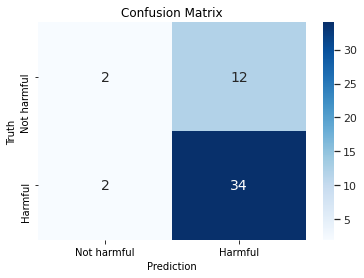

In [ ]:
#Evaluating the model : 
with torch.no_grad():
  input_ids = test_dataset[:50]['input_ids'].to(device)
  attention_mask = test_dataset[:50]['attention_mask'].to(device)
  labels = test_dataset[:50]['labels'].to(device)
  outputs = model(input_ids, attention_mask=attention_mask)
  # print(np.argmax(outputs[0].cpu().data.numpy(), axis=1))

  # print(labels.cpu().data.numpy())
  # print(torch.argmax(outputs[0]).cpu().data.numpy())
  metrics_camembert=compute_metrics(labels.cpu().data.numpy(),outputs[0].cpu().data.numpy()[:,1], confusion=True)
  print(metrics_camembert)

In [ ]:
# # Are we overfitting ? 

# train_data = DataLoader(train_dataset, batch_size=1, shuffle=True)

# for data in train_data:
#   input_ids = data['input_ids'].to(device)
#   attention_mask = data['attention_mask'].to(device)
#   labels = data['labels'].to(device)
#   outputs = model(input_ids, attention_mask=attention_mask)
#   # print(labels)
#   if torch.argmax(outputs[0])==labels:
#     acc+=1
#   # print(torch.argmax(outputs[0]))

# acc=acc/(len(train_data))
# print(acc)

We are clearly overfitting here.
The problem is it is hard to know if it is a good or a bad thing ? Indeed the dataset is not really what we want to moderate, so maybe it is okay... 

In [ ]:
metrics_df=pd.DataFrame(metrics_bow.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
df2=pd.DataFrame(metrics_tfidf.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
df3=pd.DataFrame(metrics_camembert.reshape((1,-1)), columns=["f1", "best_precision", "best_recall", "roc_auc", "acc"])
metrics_df=metrics_df.append(df2,ignore_index=True)
metrics_df=metrics_df.append(df3,ignore_index=True)


In [ ]:
metrics_df.head()

,f1,best_precision,best_recall,roc_auc,acc
0,0.886337,0.796855,0.998858,0.598020,0.796292
1,0.886563,0.797442,0.998509,0.651417,0.796821
2,0.884426,0.795409,1.000000,0.548913,0.798184


On n'a pas de meilleure performance selon le modèle choisi. 
Etonnament le modèle camembert donne une aire sous la courbe ROC plus faible que les autres, alors que le reste des indicateurs sont similaires.

Piste d'amélioration :
- Feature Engineering
- Utiliser camembert + Log reg ? 
-Try 2 epochs ? It is worse... F1 AT 0.1, confusion matrix shows worse. Same than 1 on second run
- Try 3 epoch ? Not great... 
1 epoch seems to do the job just fine. 
-Try padding = done
- Truncation does not change anything.


## Analyse : Quelles implications sur les messages à modérer A1 ? 


In [ ]:
df_a1_to_moderate=pd.read_excel("/content/drive/MyDrive/article_1_data/AmauryModerationAllMessagesInspireFrom3Aout2020.xlsx", sheet_name="ContenuToModerate")
df_a1_to_moderate=df_a1_to_moderate.drop(columns=["_id","sender","recipients.0","threadId","timestamp","EchantillonToModerate"])
df_a1_to_moderate.head()

,content
0,"Non, la physique-chimie de lycée n’a pas grand..."
1,Merci infiniment d'avoir pris autant de temps ...
2,Bonjour ! Alors non la SVT et la biologie ce n...
3,salut\nJ'aimerais savoir ce qu'est exactement ...
4,je sais pas si j'ai répondu à toutes tes quest...


In [ ]:
test_values=np.array(test["tweet"])
test_labels=np.array(test["sentiment"])

train_values=np.array(df_to_moderate["content"])
train_values=[str(train_values[i]) for i in range(len(train_values))]
train_labels=np.array(df_to_moderate["Harmful"])

In [ ]:

bow=CountVectorizer()
train_bow=bow.fit_transform(train_values)
test_bow=bow.transform(test_values)

# metrics_bow=evaluate_log_reg(train_bow, test_bow, train_labels, test_labels)

log_reg=SGDClassifier(loss="log", penalty='l2')
log_reg.fit(train_bow,train_labels)

prediction=log_reg.predict(bow.transform(df_a1_to_moderate["content"]))

In [ ]:
print(prediction)
print(f"Le modèle fait ressortir 737 messages problématiques : {sum(prediction)}")
print(f"Nombre de messages problématiques originaux : {df_a1_to_moderate.shape[0]}")

[0. 0. 0. ... 0. 0. 0.]
Le modèle fait ressortir 737 messages problématiques : 703.0
Nombre de messages problématiques originaux : 8233


In [ ]:
indexes=[ i for i in range(len(prediction)) if prediction[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes]
print(indexes)

for i in range(10): 
  print(df_a1_bow_moderate.iloc[i]["content"])

[16, 34, 36, 38, 45, 77, 79, 82, 123, 126, 141, 143, 145, 164, 166, 194, 204, 210, 220, 233, 243, 252, 275, 284, 299, 303, 316, 327, 331, 333, 337, 339, 340, 343, 353, 365, 375, 387, 388, 431, 437, 450, 453, 469, 491, 499, 504, 505, 521, 526, 527, 562, 566, 572, 574, 591, 595, 608, 641, 642, 646, 693, 694, 696, 697, 698, 699, 701, 729, 735, 749, 764, 770, 779, 803, 808, 809, 829, 838, 904, 956, 957, 976, 983, 987, 1030, 1040, 1041, 1043, 1046, 1056, 1081, 1104, 1109, 1116, 1125, 1129, 1144, 1186, 1189, 1247, 1270, 1273, 1291, 1300, 1305, 1308, 1318, 1319, 1329, 1377, 1388, 1410, 1421, 1426, 1430, 1447, 1458, 1460, 1472, 1482, 1494, 1495, 1520, 1538, 1542, 1561, 1564, 1569, 1579, 1594, 1602, 1605, 1607, 1608, 1612, 1618, 1620, 1686, 1688, 1689, 1696, 1705, 1706, 1725, 1737, 1740, 1741, 1742, 1749, 1760, 1765, 1767, 1783, 1850, 1854, 1856, 1891, 1896, 1897, 1915, 1916, 1917, 1923, 1931, 1940, 1954, 1955, 1958, 1965, 1990, 1993, 2008, 2029, 2040, 2042, 2057, 2064, 2090, 2093, 2095, 2103, 

C'est quand même encore très bof.

IL faudrait ré-entrainer avec des données plus solides d'A1 clairement. même si déjà c'est plus gérable (div par 10 du flag ?)

Si on essaie avec le modèle Camembert ? 


In [ ]:
a1_test = tokenizer(np.array(df_a1_to_moderate["content"]).tolist(), padding=True, truncation=True)


In [ ]:
# print(a1_test["input_ids"])
# # predictions=
a1_test_dataset=A1Dataset(a1_test,np.zeros(df_a1_to_moderate.shape[0]))
model.load_state_dict(torch.load("/content/drive/MyDrive/article_1_data/camembert.pt"))
predictions=[]

test_loader=DataLoader(a1_test_dataset, batch_size=16, shuffle=False)
with torch.no_grad():
  for batch in test_loader:

    inputs_test=batch["input_ids"].to(device)
    attention_mask_test=batch["attention_mask"].to(device)
    # print(model(inputs_test,attention_mask=attention_mask_test))
    outputs=model(inputs_test,attention_mask=attention_mask_test)
    predictions.append(np.argmax(outputs[0].cpu().data.numpy(), axis=1).tolist())


In [ ]:
predictions=[item for sublist in predictions for item in sublist]
print(predictions)

print(sum(predictions))
print(len(predictions))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

IT TAKES AGES BUT GOD IT IS WORTH IT :D

In [ ]:
indexes_camembert=[ i for i in range(len(predictions)) if predictions[i]==1]
df_a1_bow_moderate=df_a1_to_moderate.iloc[indexes_camembert]
print(indexes_camembert)

for i in range(51): 
  print(df_a1_bow_moderate.iloc[i]["content"])

[36, 77, 210, 316, 521, 534, 1124, 1273, 1538, 1849, 2008, 2169, 2267, 2286, 2287, 2291, 2313, 2347, 2498, 2499, 2763, 2911, 3194, 3497, 4001, 4199, 4200, 4201, 4204, 4206, 4208, 4211, 4213, 4214, 4217, 4220, 4227, 4701, 4783, 5459, 5628, 6095, 6112, 6149, 6504, 6507, 6512, 7092, 7199, 7805, 7853]
t'es un amour merciiiiiiiiii
*inébranlable est un caprice de mon correcteur automatique
Hello Léane* !! correcteur farceur :)
woaw t’es grave deter mdrr
https://drive.google.com/file/d/1lkHW998wL4xGX-ptekBuJ09iroz_PMdz/view?usp=drivesdk
Merci, tes réponses sont très complètes ! TooGoodToGo va devenir mon meilleur ami ahah
La communication aha
Après paris j’y penses paaas vrmnt pck j’veux pas partir non plus loin de chez moi, je suis vers cannes 06
Quel hasard que tu soit à pissarro !
D’accord merveaucoup pour l’aide
Insta : nonoo__o 
:)
Derien, il y a pas de quoi
Mais oui sinon c’est abusé je suis d’accord mdrr
Ok vas-y
et oui vas-y passes sur insta
Ah ouais ! En fait c’est compliqué ct’histo

## Creation of extra-features / Test a RF ? 